(lp_intro)=
# Linear Programming

In this lecture, we will need the following library. Install [ortools](https://developers.google.com/optimization) using `pip`.

In [1]:
!pip install ortools

   ━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/28.1 MB 66.6 MB/s eta 0:00:01

   ━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/28.1 MB 96.0 MB/s eta 0:00:01

   ━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━ 12.7/28.1 MB 153.2 MB/s eta 0:00:01

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━ 24.1/28.1 MB 164.0 MB/s eta 0:00:01

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 28.1/28.1 MB 170.5 MB/s eta 0:00:01

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 81.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 61.8 MB/s eta 0:00:00


  Attempting uninstall: protobuf


    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:


      Successfully uninstalled protobuf-3.20.3


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
streamlit 1.32.0 requires protobuf<5,>=3.20, but you have protobuf 5.26.1 which is incompatible.


## Overview

**Linear programming** problems either maximize or minimize
a linear objective function subject to a set of  linear equality and/or inequality constraints.

Linear programs come in pairs:

* an original  **primal** problem, and

* an associated **dual** problem.

If a primal problem involves *maximization*, the dual problem involves *minimization*.

If a primal problem involves  *minimization**, the dual problem involves **maximization*.

We provide a standard form of a linear program and methods to transform other forms of linear programming problems  into a standard form.

We tell how to solve a linear programming problem using [SciPy](https://scipy.org/) and [Google OR-Tools](https://developers.google.com/optimization).

```{seealso}
In another lecture, we will employ the linear programming method to solve the 
{doc}`optimal transport problem <tools:opt_transport>`.
```

Let's start with some standard imports.

In [2]:
import numpy as np
from ortools.linear_solver import pywraplp
from scipy.optimize import linprog
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

Let's start with some examples of linear programming problem.



## Example 1: production problem

This example was created by {cite}`bertsimas_tsitsiklis1997`

Suppose that a factory can produce two goods called Product $1$ and Product $2$.

To produce each product requires both material and labor.

Selling each product generates revenue.

Required per unit material and labor  inputs and  revenues  are shown in table below:

|          | Product 1 | Product 2 |
| :------: | :-------: | :-------: |
| Material |     2     |     5     |
|  Labor   |     4     |     2     |
| Revenue  |     3     |     4     |

30 units of material and 20 units of labor available.

A firm's problem is to construct a  production plan that uses its  30 units of materials and 20 units of labor to maximize its revenue.

Let $x_i$ denote the quantity of Product $i$ that the firm produces and $z$ denote the total revenue.

This problem can be formulated as:

$$
\begin{aligned}
\max_{x_1,x_2} \ & z = 3 x_1 + 4 x_2 \\
\mbox{subject to } \ & 2 x_1 + 5 x_2 \le 30 \\
& 4 x_1 + 2 x_2 \le 20 \\
& x_1, x_2 \ge 0 \\
\end{aligned}
$$

The following graph illustrates the firm's constraints and iso-revenue lines.

Iso-revenue lines show all the combinations of materials and labor that produce the same revenue.

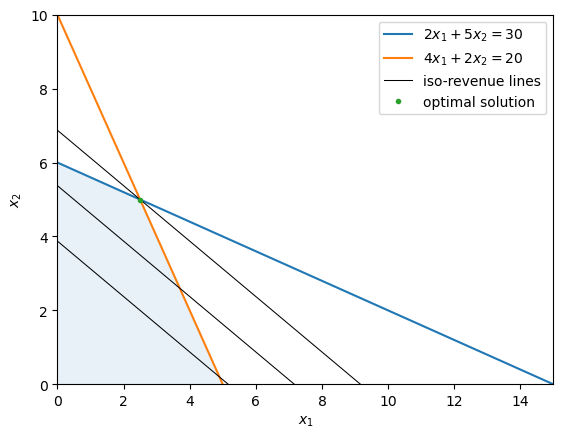

In [3]:
fig, ax = plt.subplots()
# Draw constraint lines
ax.set_xlim(0,15)
ax.set_ylim(0,10)
x1 = np.linspace(0, 15)
ax.plot(x1, 6-0.4*x1, label="$2x_1 + 5x_2=30$")
ax.plot(x1, 10-2*x1, label="$4x_1 + 2x_2=20$")


# Draw the feasible region
feasible_set = Polygon(np.array([[0, 0],[0, 6],[2.5, 5],[5, 0]]), alpha=0.1)
ax.add_patch(feasible_set)

# Draw the objective function
ax.plot(x1, 3.875-0.75*x1, label="iso-revenue lines",color='k',linewidth=0.75)
ax.plot(x1, 5.375-0.75*x1, color='k',linewidth=0.75)
ax.plot(x1, 6.875-0.75*x1, color='k',linewidth=0.75)

# Draw the optimal solution
ax.plot(2.5, 5, ".", label="optimal solution")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.legend()

plt.show()

The blue region is the feasible set within which all constraints are satisfied.

Parallel black lines are iso-revenue lines.

The firm's objective is to find the  parallel black lines to the upper boundary of the feasible set.

The intersection of the feasible set and the highest black line delineates the optimal set.

In this example, the optimal set is the point $(2.5, 5)$.



### Computation: using OR-Tools

Let's try to solve the same problem using the package `ortools.linear_solver`.



The following cell instantiates a solver and creates two variables specifying the range of values that they can have.

In [4]:
# Instantiate a GLOP(Google Linear Optimization Package) solver
solver = pywraplp.Solver.CreateSolver('GLOP')

Let's create two variables $x_1$ and $x_2$ such that they can only have nonnegative values.

In [5]:
# Create the two variables and let them take on any non-negative value.
x1 = solver.NumVar(0, solver.infinity(), 'x1')
x2 = solver.NumVar(0, solver.infinity(), 'x2')

Add the constraints to the problem.

In [6]:
# Constraint 1: 2x_1 + 5x_2 <= 30.0
solver.Add(2 * x1 + 5 * x2 <= 30.0)

# Constraint 2: 4x_1 + 2x_2 <= 20.0
solver.Add(4 * x1 + 2 * x2 <= 20.0)

<ortools.linear_solver.pywraplp.Constraint; proxy of <Swig Object of type 'operations_research::MPConstraint *' at 0x7f3b4f3f6b20> >

Let's specify the objective function. We use `solver.Maximize` method in the case when we want to maximize the objective function and in the case of minimization we can use `solver.Minimize`.

In [7]:
# Objective function: 3x_1 + 4x_2
solver.Maximize(3 * x1 + 4 * x2)

Once we solve the problem, we can check whether the solver was successful in solving the problem using its status. If it's successful, then the status will be equal to `pywraplp.Solver.OPTIMAL`.

In [8]:
# Solve the system.
status = solver.Solve()

if status == pywraplp.Solver.OPTIMAL:
    print('Objective value =', solver.Objective().Value())
    print(f'(x1, x2): ({x1.solution_value():.2}, {x2.solution_value():.2})')
else:
    print('The problem does not have an optimal solution.')

Objective value = 27.5
(x1, x2): (2.5, 5.0)


## Example 2: investment problem

We now consider a problem posed and solved by  {cite}`hu_guo2018`.

A mutual fund has $ \$ 100,000$ to be invested over a three-year horizon.

Three investment options are available:

1. Annuity:  the fund can  pay a same amount of new capital at the beginning of each of three years and receive a payoff of 130\% of total capital invested  at the end of the third year. Once the mutual fund decides to invest in this annuity, it has to keep investing in all subsequent  years in the three year horizon.

2. Bank account: the fund can deposit any amount  into a bank at the beginning of each year and receive its capital plus 6\% interest at the end of that year. In addition, the mutual fund is permitted to borrow no more than $20,000 at the beginning of each year and is asked to pay back the amount borrowed plus 6\% interest at the end of the year. The mutual fund can choose whether to deposit or borrow at the beginning of each year.

3. Corporate bond: At the beginning of the second year, a  corporate bond becomes available.
The fund can buy an amount
that is no more than $ \$ $50,000 of this bond at the beginning of the second year and  at the end of the third year receive a payout of 130\% of the amount invested in the bond.

The mutual fund's objective is to maximize total payout that it owns at the end of the third year.

We can formulate this  as a linear programming problem.

Let  $x_1$ be the amount of put in the annuity, $x_2, x_3, x_4$ be  bank deposit balances at the beginning of the three years,  and $x_5$ be the amount invested  in the corporate bond.

When $x_2, x_3, x_4$ are negative, it means that  the mutual fund has borrowed from  bank.

The table below shows the mutual fund's decision variables together with the timing protocol described above:

|                | Year 1 | Year 2 | Year 3 |
| :------------: | :----: | :----: | :----: |
|    Annuity     | $x_1$  | $x_1$  | $x_1$  |
|  Bank account  | $x_2$  | $x_3$  | $x_4$  |
| Corporate bond |   0    | $x_5$  |   0    |

The  mutual fund's decision making proceeds according to the following timing protocol:

1. At the beginning of the first year, the mutual fund decides how much to invest in the annuity and
   how much to deposit in the bank. This decision is subject to the constraint:

   $$
   x_1 + x_2 = 100,000
   $$

2. At the beginning of the second year, the mutual fund has a bank balance  of $1.06 x_2$.
   It must keep $x_1$ in the annuity. It can choose to put $x_5$ into the corporate bond,
   and put $x_3$ in the bank. These decisions are restricted by

   $$
   x_1 + x_5 = 1.06 x_2 - x_3
   $$

3. At the beginning of the third year, the mutual fund has a bank account balance equal
   to $1.06 x_3$. It must again invest  $x_1$ in the annuity,
   leaving it with  a bank account balance equal to $x_4$. This situation is summarized by the restriction:

   $$
   x_1 = 1.06 x_3 - x_4
   $$

The mutual fund's objective function, i.e., its wealth at the end of the third year is:

$$
1.30 \cdot 3x_1 + 1.06 x_4 + 1.30 x_5
$$

Thus, the mutual fund confronts the linear program:

$$
\begin{aligned}
\max_{x} \ & 1.30 \cdot 3x_1 + 1.06 x_4 + 1.30 x_5 \\
\mbox{subject to } \ & x_1 + x_2 = 100,000\\
 & x_1 - 1.06 x_2 + x_3 + x_5 = 0\\
 & x_1 - 1.06 x_3 + x_4 = 0\\
 & x_2 \ge -20,000\\
 & x_3 \ge -20,000\\
 & x_4 \ge -20,000\\
 & x_5 \le 50,000\\
 & x_j \ge 0, \quad j = 1,5\\
 & x_j \ \text{unrestricted}, \quad j = 2,3,4\\
\end{aligned}
$$



### Computation: using OR-Tools

Let's try to solve the above problem using the package `ortools.linear_solver`.

The following cell instantiates a solver and creates two variables specifying the range of values that they can have.

In [9]:
# Instantiate a GLOP(Google Linear Optimization Package) solver
solver = pywraplp.Solver.CreateSolver('GLOP')

Let's create five variables $x_1, x_2, x_3, x_4,$ and $x_5$ such that they can only have the values defined in the above constraints.

In [10]:
# Create the variables using the ranges available from constraints
x1 = solver.NumVar(0, solver.infinity(), 'x1')
x2 = solver.NumVar(-20_000, solver.infinity(), 'x2')
x3 = solver.NumVar(-20_000, solver.infinity(), 'x3')
x4 = solver.NumVar(-20_000, solver.infinity(), 'x4')
x5 = solver.NumVar(0, 50_000, 'x5')

Add the constraints to the problem.

In [11]:
# Constraint 1: x_1 + x_2 = 100,000
solver.Add(x1 + x2 == 100_000.0)

# Constraint 2: x_1 - 1.06 * x_2 + x_3 + x_5 = 0
solver.Add(x1 - 1.06 * x2 + x3 + x5 == 0.0)

# Constraint 3: x_1 - 1.06 * x_3 + x_4 = 0
solver.Add(x1 - 1.06 * x3 + x4 == 0.0)

<ortools.linear_solver.pywraplp.Constraint; proxy of <Swig Object of type 'operations_research::MPConstraint *' at 0x7f3b4f3f6e80> >

Let's specify the objective function.

In [12]:
# Objective function: 1.30 * 3 * x_1 + 1.06 * x_4 + 1.30 * x_5
solver.Maximize(1.30 * 3 * x1 + 1.06 * x4 + 1.30 * x5)

Let's solve the problem and check the status using `pywraplp.Solver.OPTIMAL`.

In [13]:
# Solve the system.
status = solver.Solve()

if status == pywraplp.Solver.OPTIMAL:
    print('Objective value =', solver.Objective().Value())
    x1_sol = round(x1.solution_value(), 3)
    x2_sol = round(x2.solution_value(), 3)
    x3_sol = round(x1.solution_value(), 3)
    x4_sol = round(x2.solution_value(), 3)
    x5_sol = round(x1.solution_value(), 3)
    print(f'(x1, x2, x3, x4, x5): ({x1_sol}, {x2_sol}, {x3_sol}, {x4_sol}, {x5_sol})')
else:
    print('The problem does not have an optimal solution.')

Objective value = 141018.24349792692
(x1, x2, x3, x4, x5): (24927.755, 75072.245, 24927.755, 75072.245, 24927.755)


OR-Tools tells us that  the best investment strategy is:

1. At the beginning of the first year, the mutual fund should buy $ \$24,927.755$ of the annuity. Its bank account balance should be $ \$75,072.245$.

2. At the beginning of the second year, the mutual fund should buy $ \$24,927.755$ of the corporate bond and keep invest in the annuity. Its bank balance should be $ \$24,927.755$.

3. At the beginning of the third year, the bank balance should be $ \$75,072.245 $.

4. At the end of the third year, the mutual fund will get payouts from the annuity and corporate bond and repay its loan from the bank. At the end  it will own $ \$141,018.24 $, so that it's total net  rate of return over the three periods is $ 41.02\%$.



## Standard form

For purposes of

* unifying linear programs that are initially stated in superficially different forms, and

* having a form that is convenient to put into black-box software packages,

it is useful to devote some effort to describe a **standard form**.

Our standard form  is:

$$
\begin{aligned}
\min_{x} \ & c_1 x_1 + c_2 x_2 + \dots + c_n x_n  \\
\mbox{subject to } \ & a_{11} x_1 + a_{12} x_2 + \dots + a_{1n} x_n = b_1 \\
 & a_{21} x_1 + a_{22} x_2 + \dots + a_{2n} x_n = b_2 \\
 & \quad \vdots \\
 & a_{m1} x_1 + a_{m2} x_2 + \dots + a_{mn} x_n = b_m \\
 & x_1, x_2, \dots, x_n \ge 0 \\
\end{aligned}
$$

Let

$$
A = \begin{bmatrix}
a_{11} & a_{12} & \dots & a_{1n} \\
a_{21} & a_{22} & \dots & a_{2n} \\
  &   & \vdots &   \\
a_{m1} & a_{m2} & \dots & a_{mn} \\
\end{bmatrix}, \quad
b = \begin{bmatrix} b_1 \\ b_2 \\ \vdots \\ b_m \\ \end{bmatrix}, \quad
c = \begin{bmatrix} c_1 \\ c_2 \\ \vdots \\ c_n \\ \end{bmatrix}, \quad
x = \begin{bmatrix} x_1 \\ x_2 \\ \vdots \\ x_n \\ \end{bmatrix}. \quad
$$

The standard form linear programming problem can be expressed concisely as:

$$
\begin{aligned}
\min_{x} \ & c'x \\
\mbox{subject to } \ & Ax = b\\
 & x \geq 0\\
\end{aligned}
$$ (lpproblem)

Here, $Ax = b$ means that  the $i$-th entry of $Ax$  equals the $i$-th entry of $b$ for every $i$.

Similarly, $x \geq 0$ means that  $x_j$ is greater than equal to $0$ for every $j$.

### Useful transformations

It is useful to know how to transform a problem that initially is not stated in the standard form into one that is.

By deploying the following steps, any linear programming problem can be transformed into an  equivalent  standard form linear programming problem.

1. Objective function: If a problem is originally a constrained *maximization* problem, we can construct a new objective function that  is the additive inverse of the original objective function. The transformed problem is then a *minimization* problem.

2. Decision variables: Given a variable $x_j$ satisfying $x_j \le 0$, we can introduce a new variable $x_j' = - x_j$ and substitute it into original problem. Given a free variable $x_i$ with no restriction on its sign, we can introduce two new variables $x_j^+$ and $x_j^-$ satisfying $x_j^+, x_j^- \ge 0$ and replace $x_j$ by $x_j^+ - x_j^-$.

3. Inequality constraints: Given an inequality constraint $\sum_{j=1}^n a_{ij}x_j \le 0$, we can introduce a new variable $s_i$, called a **slack variable** that satisfies $s_i \ge 0$ and replace the original constraint by $\sum_{j=1}^n a_{ij}x_j + s_i = 0$.

Let's apply the above steps to the two examples described above.

### Example 1: production problem

The original problem is:

$$
\begin{aligned}
\max_{x_1,x_2} \ & 3 x_1 + 4 x_2 \\
\mbox{subject to } \ & 2 x_1 + 5 x_2 \le 30 \\
& 4 x_1 + 2 x_2 \le 20 \\
& x_1, x_2 \ge 0 \\
\end{aligned}
$$

This problem is equivalent to the following problem with a standard form:

$$
\begin{aligned}
\min_{x_1,x_2} \ & -(3 x_1 + 4 x_2) \\
\mbox{subject to } \ & 2 x_1 + 5 x_2 + s_1 = 30 \\
& 4 x_1 + 2 x_2 + s_2 = 20 \\
& x_1, x_2, s_1, s_2 \ge 0 \\
\end{aligned}
$$



### Computation: using SciPy

The package `scipy.optimize` provides a function `linprog` to solve linear programming problems with a form below:

$$
\begin{aligned}
\min_{x} \ & c' x  \\
\mbox{subject to } \ & A_{ub}x \le b_{ub} \\
 & A_{eq}x = b_{eq} \\
 & l \le x \le u \\
\end{aligned}
$$

$A_{eq}, b_{eq}$ denote the equality constraint matrix and vector, and $A_{ub}, b_{ub}$ denote the inequality constraint matrix and vector.

```{note}
By default $l = 0$ and $u = \text{None}$ unless explicitly specified with the argument `bounds`.
```

Let's now try to solve the Problem 1 using SciPy.

In [14]:
# Construct parameters
c_ex1 = np.array([3, 4])

# Inequality constraints
A_ex1 = np.array([[2, 5],
                  [4, 2]])
b_ex1 = np.array([30,20])

Once we solve the problem, we can check whether the solver was successful in solving the problem using the boolean attribute `success`. If it's successful, then the `success` attribute is set to `True`.

In [15]:
# Solve the problem
# we put a negative sign on the objective as linprog does minimization
res_ex1 = linprog(-c_ex1, A_ub=A_ex1, b_ub=b_ex1)

if res_ex1.success:
    # We use negative sign to get the optimal value (maximized value)
    print('Optimal Value:', -res_ex1.fun)
    print(f'(x1, x2): {res_ex1.x[0], res_ex1.x[1]}')
else:
    print('The problem does not have an optimal solution.')

Optimal Value: 27.5
(x1, x2): (2.5, 5.0)


The optimal plan tells the  factory to produce $2.5$ units of Product 1 and $5$ units of  Product 2; that  generates a maximizing value of  revenue of $27.5$.

We are using the `linprog` function as a *black box*.

Inside it, Python first  transforms the problem into  standard form.

To do that, for each inequality constraint it generates one slack variable.

Here the vector of slack variables is a two-dimensional NumPy array that  equals $b_{ub} - A_{ub}x$.

See the [official documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linprog.html#scipy.optimize.linprog) for more details.

```{note}
This problem is to maximize the objective, so that we need to put a minus sign in front of parameter vector $c$.
```



### Example 2: investment problem

The original problem is:

$$
\begin{aligned}
\max_{x} \ & 1.30 \cdot 3x_1 + 1.06 x_4 + 1.30 x_5 \\
\mbox{subject to } \ & x_1 + x_2 = 100,000\\
 & x_1 - 1.06 x_2 + x_3 + x_5 = 0\\
 & x_1 - 1.06 x_3 + x_4 = 0\\
 & x_2 \ge -20,000\\
 & x_3 \ge -20,000\\
 & x_4 \ge -20,000\\
 & x_5 \le 50,000\\
 & x_j \ge 0, \quad j = 1,5\\
 & x_j \ \text{unrestricted}, \quad j = 2,3,4\\
\end{aligned}
$$

This problem is equivalent to the following problem with a standard form:

$$
\begin{aligned}
\min_{x} \ & -(1.30 \cdot 3x_1 + 1.06 x_4^+ - 1.06 x_4^- + 1.30 x_5) \\
\mbox{subject to } \ & x_1 + x_2^+ - x_2^- = 100,000\\
 & x_1 - 1.06 (x_2^+ - x_2^-) + x_3^+ - x_3^- + x_5 = 0\\
 & x_1 - 1.06 (x_3^+ - x_3^-) + x_4^+ - x_4^- = 0\\
 & x_2^- - x_2^+ + s_1 = 20,000\\
 & x_3^- - x_3^+ + s_2 = 20,000\\
 & x_4^- - x_4^+ + s_3 = 20,000\\
 & x_5 + s_4 = 50,000\\
 & x_j \ge 0, \quad j = 1,5\\
 & x_j^+, x_j^- \ge 0, \quad j = 2,3,4\\
 & s_j \ge 0, \quad j = 1,2,3,4\\
\end{aligned}
$$

In [16]:
# Construct parameters
rate = 1.06

# Objective function parameters
c_ex2 = np.array([1.30*3, 0, 0, 1.06, 1.30])

# Inequality constraints
A_ex2 = np.array([[1,  1,  0,  0,  0],
                  [1, -rate, 1, 0, 1],
                  [1, 0, -rate, 1, 0]])
b_ex2 = np.array([100_000, 0, 0])

# Bounds on decision variables
bounds_ex2 = [(  0,    None),
              (-20_000, None),
              (-20_000, None),
              (-20_000, None),
              (  0,   50_000)]

Let's solve the problem and check the status using `success` attribute.

In [17]:
# Solve the problem
res_ex2 = linprog(-c_ex2, A_eq=A_ex2, b_eq=b_ex2,
                  bounds=bounds_ex2)

if res_ex2.success:
    # We use negative sign to get the optimal value (maximized value)
    print('Optimal Value:', -res_ex2.fun)
    x1_sol = round(res_ex2.x[0], 3)
    x2_sol = round(res_ex2.x[1], 3)
    x3_sol = round(res_ex2.x[2], 3)
    x4_sol = round(res_ex2.x[3], 3)
    x5_sol = round(res_ex2.x[4], 3)
    print(f'(x1, x2, x3, x4, x5): {x1_sol, x2_sol, x3_sol, x4_sol, x5_sol}')
else:
    print('The problem does not have an optimal solution.')

Optimal Value: 141018.24349792697
(x1, x2, x3, x4, x5): (24927.755, 75072.245, 4648.825, -20000.0, 50000.0)


SciPy tells us that  the best investment strategy is:

1. At the beginning of the first year, the mutual fund should buy $ \$24,927.75$ of the annuity. Its bank account balance should be $ \$75,072.25$.

2. At the beginning of the second year, the mutual fund should buy $ \$50,000 $ of the corporate bond and keep invest in the annuity. Its bank account balance should be $ \$ 4,648.83$.

3. At the beginning of the third year, the mutual fund should borrow $ \$20,000$ from the bank and invest in the annuity.

4. At the end of the third year, the mutual fund will get payouts from the annuity and corporate bond and repay its loan from the bank. At the end  it will own $ \$141,018.24 $, so that it's total net  rate of return over the three periods is $ 41.02\% $.



```{note}
You might notice the difference in the values of optimal solution using OR-Tools and SciPy but the optimal value is the same. It is because there can be many optimal solutions for the same problem.
```



## Exercises

```{exercise-start}
:label: lp_intro_ex1
```

Implement a new extended solution for the Problem 1 where in the factory owner decides that number of units of Product 1 should not be less than the number of units of Product 2.

```{exercise-end}
```


```{solution-start} lp_intro_ex1
:class: dropdown
```

So we can reformulate the problem as:

$$
\begin{aligned}
\max_{x_1,x_2} \ & z = 3 x_1 + 4 x_2 \\
\mbox{subject to } \ & 2 x_1 + 5 x_2 \le 30 \\
& 4 x_1 + 2 x_2 \le 20 \\
& x_1 \ge x_2 \\
& x_1, x_2 \ge 0 \\
\end{aligned}
$$

In [18]:
# Instantiate a GLOP(Google Linear Optimization Package) solver
solver = pywraplp.Solver.CreateSolver('GLOP')

# Create the two variables and let them take on any non-negative value.
x1 = solver.NumVar(0, solver.infinity(), 'x1')
x2 = solver.NumVar(0, solver.infinity(), 'x2')

In [19]:
# Constraint 1: 2x_1 + 5x_2 <= 30.0
solver.Add(2 * x1 + 5 * x2 <= 30.0)

# Constraint 2: 4x_1 + 2x_2 <= 20.0
solver.Add(4 * x1 + 2 * x2 <= 20.0)

# Constraint 3: x_1 >= x_2
solver.Add(x1 >= x2)

<ortools.linear_solver.pywraplp.Constraint; proxy of <Swig Object of type 'operations_research::MPConstraint *' at 0x7f3b4f3f58f0> >

In [20]:
# Objective function: 3x_1 + 4x_2
solver.Maximize(3 * x1 + 4 * x2)

In [21]:
# Solve the system.
status = solver.Solve()

if status == pywraplp.Solver.OPTIMAL:
    print('Objective value =', solver.Objective().Value())
    x1_sol = round(x1.solution_value(), 2)
    x2_sol = round(x2.solution_value(), 2)
    print(f'(x1, x2): ({x1_sol}, {x2_sol})')
else:
    print('The problem does not have an optimal solution.')

Objective value = 23.333333333333336
(x1, x2): (3.33, 3.33)


```{solution-end}
```

```{exercise-start}
:label: lp_intro_ex2
```

A carpenter manufactures $2$ products - $A$ and $B$.


Product $A$ generates a profit of $23$ and product $B$ generates a profit of $10$.

It takes $2$ hours for the carpenter to produce $A$ and $0.8$ hours to produce $B$.

Moreover, he can't spend more than $25$ hours per week and the total number of units of $A$ and $B$ should not be greater than $20$.

Find the number of units of $A$ and product $B$ that he should manufacture in order to maximise his profit.

```{exercise-end}
```


```{solution-start} lp_intro_ex2
:class: dropdown
```

Let us assume the carpenter produces $x$ units of $A$ and $y$ units of $B$.

So we can formulate the problem as:

$$
\begin{aligned}
\max_{x,y} \ & z = 23 x + 10 y \\
\mbox{subject to } \ & x + y \le 20 \\
& 2 x + 0.8 y \le 25 \\
\end{aligned}
$$

In [22]:
# Instantiate a GLOP(Google Linear Optimization Package) solver
solver = pywraplp.Solver.CreateSolver('GLOP')

Let's create two variables $x_1$ and $x_2$ such that they can only have nonnegative values.

In [23]:
# Create the two variables and let them take on any non-negative value.
x = solver.NumVar(0, solver.infinity(), 'x')
y = solver.NumVar(0, solver.infinity(), 'y')

In [24]:
# Constraint 1: x + y <= 20.0
solver.Add(x + y <= 20.0)

# Constraint 2: 2x + 0.8y <= 25.0
solver.Add(2 * x + 0.8 * y <= 25.0)

<ortools.linear_solver.pywraplp.Constraint; proxy of <Swig Object of type 'operations_research::MPConstraint *' at 0x7f3b4f3f5f80> >

In [25]:
# Objective function: 23x + 10y
solver.Maximize(23 * x + 10 * y)

In [26]:
# Solve the system.
status = solver.Solve()

if status == pywraplp.Solver.OPTIMAL:
    print('Maximum Profit =', solver.Objective().Value())
    x_sol = round(x.solution_value(), 3)
    y_sol = round(y.solution_value(), 3)
    print(f'(x, y): ({x_sol}, {y_sol})')
else:
    print('The problem does not have an optimal solution.')

Maximum Profit = 297.5
(x, y): (7.5, 12.5)


```{solution-end}
```